# Free energy corrections <br>
Here, I'll demonstrate how to:
1. query forward/backward (MM to ML/MM) NEQ work dictionaries for ligand series and compute BAR free energy corrections.
2. extract the MM Perses relative free energy `Simulation` objects
3. plot MM and ML/MM absolute, relative free energies

In [1]:
import numpy as np
import os

`work_dictionaries.npz` contains two dictionaries. The first is an _aggregated_ work dictionary (in kT) that contains the forward and backward works of each ligand for each phase (solvent, complex), as well as for each repeated trial of ligand X. The second dictionary is a _concatenated_ work dictionary that is simply a concatenation of all of the _aggregated_ work repeats. Let's load those, as well as the experimental free energy (in kcal mol$^{-1}$) of the Tyk2 ligands reported in

```Wang, L.; Wu, Y.; Deng, Y.; Kim, B.; Pierce, L.; Krilov, G.; Lupyan, D.; Robinson, S.; Dahlgren, M. K.; Greenwood, J.; Romero, D. L.; Masse, C.; Knight, J. L.; Steinbrecher, T.; Beuming, T.; Damm, W.; Harder, E.; Sherman, W.; Brewer, M.; Wester, R.; Murcko, M.; Frye, L.; Farid, R.; Lin, T.; Mobley, D. L.; Jorgensen, W. L.; Berne, B. J.; Friesner, R. A.; Abel, R. Accurate and Reliable Prediction of Relative Ligand Binding Potency in Prospective Drug Discovery by Way of a Modern Free-Energy Calculation Protocol and Force Field. J. Am. Chem. Soc. 2015, 137 (7), 2695–2703. https://doi.org/10.1021/ja512751q.```

In [2]:
work_dictionaries = np.load('work_dictionaries.npz', allow_pickle=True)
agg_dict, concat_dict = work_dictionaries['arr_0'].item(), work_dictionaries['arr_1'].item()
experimental = np.load('tyk2_experimental.npz')['arr_0']

Now, I'll compute BAR estimates for each phase of each ligand...

In [3]:
from qmlify.analysis import compute_BAR
agg_BAR = compute_BAR(agg_dict)
concat_BAR = compute_BAR(concat_dict)

and plot the forward/backward work distributions and BAR free energy estimates

In [4]:
from qmlify.plotting import *

generating 4 plots...
plotting ligands: 0 through 4
plotting ligands: 4 through 8
plotting ligands: 8 through 12
plotting ligands: 12 through 16


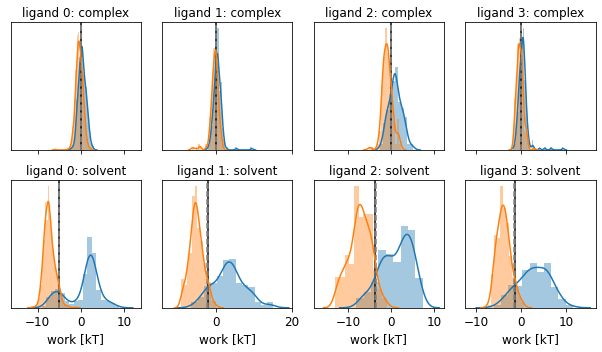

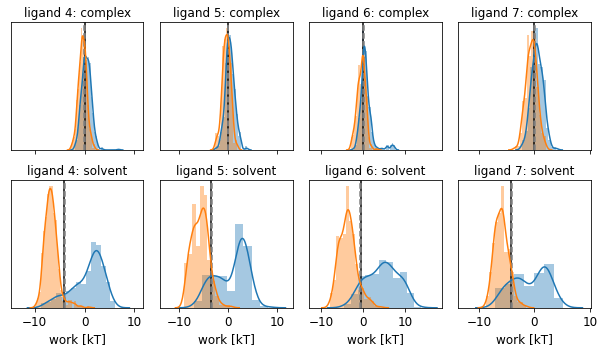

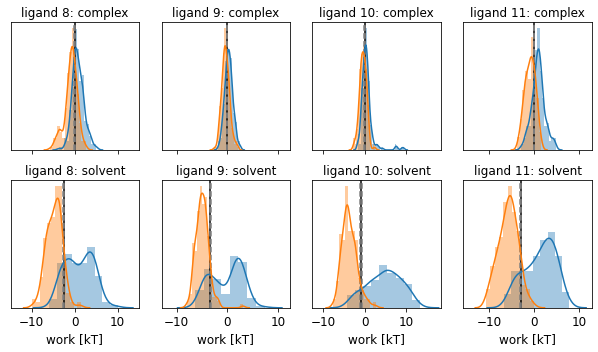

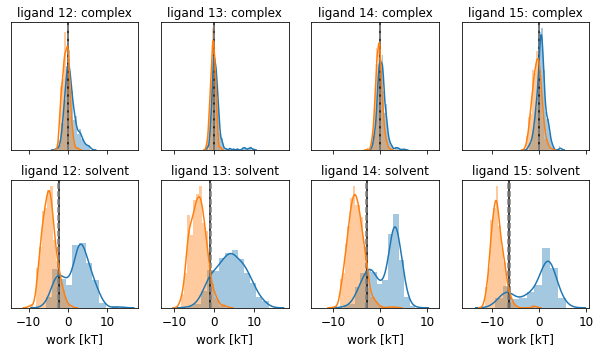

In [5]:
generate_work_distribution_plots(concat_dict, concat_BAR, 'tyk2')

Now, I'll reformat the BAR dictionary to plot corrections. (the returned BAR dictionary above is of the form `[(dG_calculated, ddG_calculated)]`, but we just want it as `(dG_calculated, ddG_calculated)`. 

In [6]:
corrected_concat_BAR = {}
for key, val in concat_BAR.items():
    new_val = {_key: _val[0] for _key, _val in val.items()}
    corrected_concat_BAR[key] = new_val

Now, I'll extract the Perses Replica Exchange relative binding free energies...

In [7]:
all_sims = []
for result_file in os.listdir('mm_data/'):
    if result_file[-2:] == 'pi':
        results = np.load(f"mm_data/{result_file}", allow_pickle=True)
        all_sims.append(results)

And lastly, I'll plot the absolute and relative free energy plots with respect to experimental data. These include MM only, as well as with incuded ML/MM corrections...

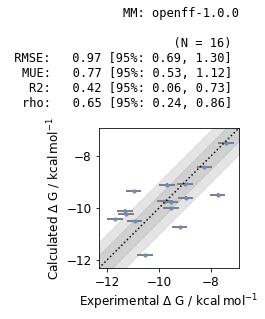

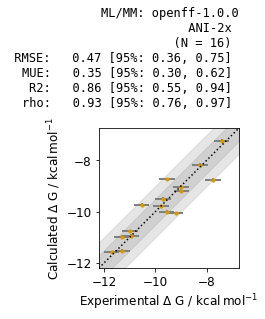

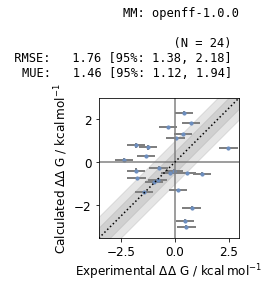

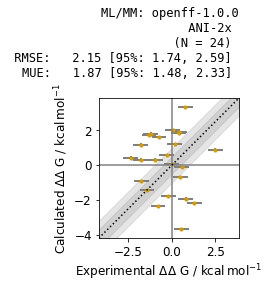

In [8]:
from qmlify.analysis import analyze_mlmm
from simtk import unit
analyze_mlmm(all_sims, corrected_concat_BAR, experimental = experimental, temperature = 300*unit.kelvin)

In [9]:
def analyze_mlmm(mm_results,
                 ml_corrections,
                 experimental=None,
                 experimental_error=0.3,
                 MM_ff='openff-1.0.0',
                 ML_ff='ANI-2x',
                 temperature=300.0 * unit.kelvin):
    """
    Runs  MM-> ML/MM analysis, and generates four graphs:
    - MM relative
    - MM absolute
    - ML/MM relative
    - ML/MM absolute

    >>>  analysis.analyze_mlmm(all_sims, ani_results, experimental=experimental, experimental_error=0.18)

    Parameters
    ----------
    mm_results : list(perses.analysis.load_simulations.Simulation)
        List of perses Simulation objects of MM calculations
    ml_corrections : dict(int:dict(phase:tuple))
        MM -> ML/MM corrections and associated uncertainty
        i.e. {0:'solvent': (0.2, 0.1)} if ligand index 0 has a correction of 0.2 (0.1) kT in solvent phase
    experimental : list(float), default=None
        list of experimental binding free energies in kcal/mol
        if None function will return
    experimental_error: float or list of floats, default=0.3
        experimental uncertainty, either one value for the whole ligand set,
        or a list per ligand in kcal/mol
        Default value of 0.3 from
    MM_ff : str, default='openff-1.0.0'
        string name of MM ff for labelling plots
    ML_ff : str, default='ANI-2x'
        string name of ML ff for labelling plots

    Returns
    -------

    """
    from openmmtools.constants import kB
    from qmlify.analysis import _make_ml_graph, _make_mm_graph, _plot_absolute, _plot_relative, _per_ligand_correction, _relative_corrections
    import networkx as nx
    kT = temperature*kB

    #broadcast the experimental free energy to _all_ experimental results
    if isinstance(experimental_error, float):
        experimental_error = len(experimental) * [experimental_error]

    assert len(experimental) == len(experimental_error), \
        f"Need either one experimental uncertainty for ligand set, or an experimental_error per ligand. {len(experimental)} experimental DGs, with {len(experimental_error)} dDGs."

    mm_g = _make_mm_graph(mm_results, experimental, experimental_error) #compute a digraph of MM free energies
#     return mm_g
    binding_corrections = _per_ligand_correction(ml_corrections, kT) #query and compute the binding free energy corrections
    shifted_corrections = _relative_corrections(binding_corrections) #shift the binding free energy corrections off from the minimal correction (not strictly necessary)
    ml_g = _make_ml_graph(mm_g, shifted_corrections)
    _plot_absolute(mm_g, experimental, name='MM', MM_ff=MM_ff, color='#6C8EBF')
    _plot_absolute(ml_g, experimental, name='ML/MM', MM_ff=MM_ff, ML_ff=ML_ff, color='#D79B00')
    _plot_relative(mm_g, name='MM', MM_ff=MM_ff, color='#6C8EBF')
    _plot_relative(ml_g, name='ML/MM', MM_ff=MM_ff, ML_ff=ML_ff, color='#D79B00')
    return mm_g

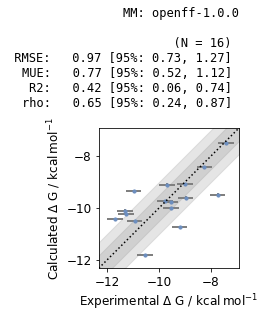

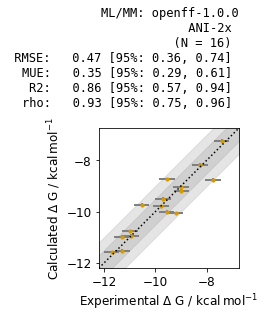

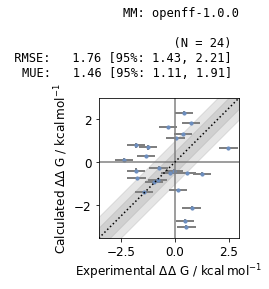

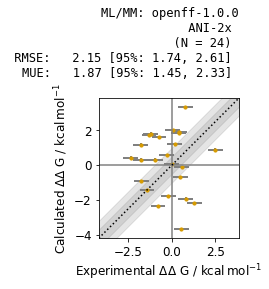

In [10]:
edit = analyze_mlmm(all_sims, corrected_concat_BAR, experimental = experimental, temperature = 300*unit.kelvin)

In [11]:
for edge in un.edges(data=True):
    print(edge)
    break

NameError: name 'un' is not defined

In [ ]:
for edge in un.edges(data=True):
    diff = (un.nodes[edge[0]]['exp_DG'] - un.nodes[edge[1]]['exp_DG'])
    print(edge[2])
    plt.scatter(edge[2]['exp_DDG'],diff)

In [ ]:
for edge in edit.edges(data=True):
    diff = (edit.nodes[edge[0]]['exp_DG'] - edit.nodes[edge[1]]['exp_DG'])
    diff = experimental[edge[0]] - experimental[edge[1]]
    print(edge[2])
    plt.scatter(edge[2]['exp_DDG'],diff)

In [ ]:
print(experimental)

for node in edit.nodes(data=True):
    print(node[1]['exp_DG'])
    plt.scatter(experimental[node[0]],node[1]['exp_DG'])

In [ ]:
edit.nodes[0]